In [1]:
#ANDRES LO NECESITA
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


4. Tarea 4: Modelamiento
4.1 Particionamiento del conjunto de datos en entrenamiento y prueba
4.2 Entrenamiento de un primer modelo de regresión lineal
4.3 Entrenamiento de un segundo modelo aplicando normalización
4.4 Validación de los supuestos de la regresión



In [2]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats
from sklearn.linear_model import Lasso

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

### Carga de datos

In [4]:
#ANDRES LO NECESITA
path = '/content/drive/MyDrive/Colab Notebooks/Analítica Computacional/Proyecto 1/data.txt' # Andrés
data_df = pd.read_csv(path, sep=',')
data_df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [ ]:
data_df = pd.read_csv("data.txt", sep=',')
data_df.head()

## Tarea 4: Modelamiento

#### 4.1 Preparación de datos: Arreglo nulos y Datos atipicos

#### 4.2 Eliminación variables no deseadas

In [44]:
#Buscando eliminar la indexación de las observaciones en el tiempo, y mantener estas independientes entre si, se elimina la variable date
#Se elimina incentve, debido a que a pesar de ser tipo Int64
data_df = data_df.drop(['date','incentive'], axis = 1)
data_df.shape


(1197, 13)

#### 4.3 Transformación Variables Dumies

In [45]:
#Variables Dummies
# Copiar el DataFrame original data_df
data_df_modeling = data_df.copy()

# Obtener variables categóricas
variables_categoricas = ['quarter', 'department', 'day', 'team','no_of_style_change']

# Convertir variables categóricas en variables dummy y agregarlas al DataFrame copiado
for variable in variables_categoricas:
    dummies = pd.get_dummies(data_df_modeling[variable], prefix=variable, drop_first=True)
    data_df_modeling = pd.concat([data_df_modeling, dummies], axis=1)
    data_df_modeling.drop(variable, axis=1, inplace=True)

# Ver las primeras filas del DataFrame copiado con las variables dummy
data_df_modeling.head()

,targeted_productivity,smv,wip,over_time,idle_time,idle_men,no_of_workers,actual_productivity,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5,department_finishing,department_sweing,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12,no_of_style_change_1,no_of_style_change_2
0,0.80,26.16,1108.0,7080,0.0,0,59.0,0.940725,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0.75,3.94,NaN,960,0.0,0,8.0,0.886500,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.80,11.41,968.0,3660,0.0,0,30.5,0.800570,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.80,11.41,968.0,3660,0.0,0,30.5,0.800570,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.80,25.90,1170.0,1920,0.0,0,56.0,0.800382,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


#### 4.4 Imputación variable wip

In [46]:
# Calcular la media de la columna 'wip'
media_wip = data_df_modeling['wip'].mean()

# Imputar los valores faltantes en la columna 'wip' con la media
data_df_modeling['wip'] = data_df_modeling['wip'].fillna(media_wip)

# Verificar si se han imputado correctamente los valores
print(data_df_modeling['wip'].isnull().sum())

0


#### 4.5 Mirando nuevamente las correlaciones

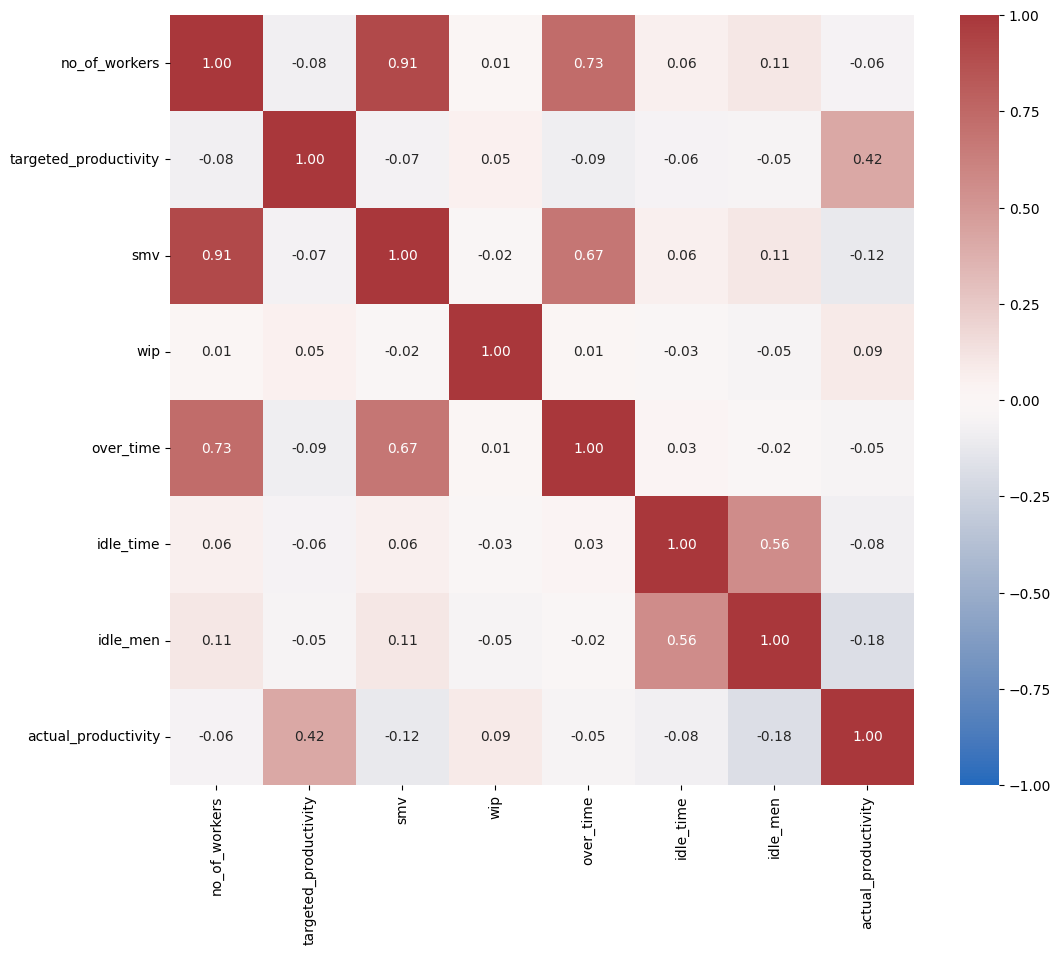

In [47]:
correlation_matrix = data_df_modeling[features_numericas].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='vlag', annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.show()

#### 4.6 Particionamiento del conjunto de datos en entrenamiento y prueba

Se desea construir un modelo que se ajuste bien a los datos de entrenamiento, pero que además se comporte de forma similar con datos previamente desconocidos.
Metodológicamente, una práctica común para validar esto es separando el conjunto de datos etiquetado en dos partes: entrenamiento y prueba. La proporción reservada para probar el modelo es definida por el analista, pero un valor común es 30%.

In [160]:
#Separar variables indepnedientes y de interes
X = data_df_modeling.drop("actual_productivity", axis=1)
Y = data_df_modeling["actual_productivity"]

In [ ]:
#Normalizar variables númericas: features_numericas
features_numericas_wiyhout_y= features_numericas
features_numericas_wiyhout_y.remove('actual_productivity')

In [161]:
#Separamos las muestras
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

#Escalamiento
# Inicializar el objeto StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

#Escalamiento en X
X_train[features_numericas] = scaler_X.fit_transform(X_train[features_numericas])
X_test[features_numericas] = scaler_X.transform(X_test[features_numericas])

#Adecuamos a numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

#Desviacion original
print("Std de y: ",np.mean(y_train, axis=0) )

#Escalamiento en Y
y_train= scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

#Imprimimos dimensiones
print("Train shape:  ",X_train.shape, y_train.shape)
print("Test shape:  ",X_test.shape, y_test.shape)

#Media y desvest
print("Media de X_train_scaled:", np.mean(X_train, axis=0))
print("Media de y_train_scaled:", np.mean(y_train, axis=0))



Std de y:  [0.73422872]
Train shape:   (837, 31) (837, 1)
Test shape:   (360, 31) (360, 1)
Media de X_train_scaled: [ 4.07479705e-16  7.21578644e-17  1.06114507e-17  3.39566421e-17
 -6.36687039e-18  1.16725957e-17  2.65286266e-17  2.90322581e-01
  1.64874552e-01  2.03106332e-01  3.82317802e-02  2.12664277e-01
  5.60334528e-01  1.51732378e-01  1.67264038e-01  1.72043011e-01
  1.72043011e-01  1.70848268e-01  1.06332139e-01  8.24372760e-02
  8.96057348e-02  7.76583035e-02  7.28793309e-02  8.24372760e-02
  8.96057348e-02  8.72162485e-02  6.81003584e-02  7.28793309e-02
  8.36320191e-02  1.01553166e-01  2.62843489e-02]
Media de y_train_scaled: [-3.225881e-16]


#### 4.7 Entrenamiento de un primer modelo de regresión lineal

Se dice que la regresión es lineal dado que se asume una relación lineal entre las variables de entrada (features) y la variable objetivo (target).
En Scikit-Learn existen varias formas de implementar el algoritmo de regresión lieal, pero dado que el objetivo de esta practica esta enfocado en el análisis del modelo resultante y no tanto del algoritmo o del proceso de entrenamiento, se utilizará la implementación más sencilla dada por la clase LinearRegression.

In [162]:
# Crear el modelo
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

coeficientes=model.coef_[0]
features = X.columns

for i, feature in enumerate(features):
  print(f"Coeficiente de {feature}: {coeficientes[i]}")

print(f"\nIntercepto: {model.intercept_[0]}")

Coeficiente de targeted_productivity: 0.3639243931469222
Coeficiente de smv: -0.48380253422390396
Coeficiente de wip: 0.026105477787722136
Coeficiente de over_time: -0.10983564163871604
Coeficiente de idle_time: -0.004014728267768326
Coeficiente de idle_men: -0.15092317991079873
Coeficiente de no_of_workers: 0.8521720357268302
Coeficiente de quarter_Quarter2: 0.03610839088081394
Coeficiente de quarter_Quarter3: -0.022261057684136904
Coeficiente de quarter_Quarter4: -0.07678171662494507
Coeficiente de quarter_Quarter5: 0.46453080487045073
Coeficiente de department_finishing : 0.3727622988279803
Coeficiente de department_sweing: -0.4456328071455973
Coeficiente de day_Saturday: 0.17970032504936653
Coeficiente de day_Sunday: 0.002944458286097182
Coeficiente de day_Thursday: -0.10937174852754007
Coeficiente de day_Tuesday: 0.12369100040181255
Coeficiente de day_Wednesday: -0.010722673896913058
Coeficiente de team_2: -0.26649902735495856
Coeficiente de team_3: -0.010132196351016691
Coeficien

**Validación Cuantitativa**

In [163]:
# Obtener las predicciones para el set Train
y_pred = model.predict(X_train)
y_train_original = y_train
y_pred = scaler_y.inverse_transform(y_pred)
y_train_original = scaler_y.inverse_transform(y_train)

# MAE
mae = mean_absolute_error(y_train_original, y_pred)
# MSE
mse = mean_squared_error(y_train_original, y_pred)
# RMSE
rmse = np.sqrt(mse)
# Imprimir los resultados
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", model.score(X_train,y_train))

MAE: 0.10117637913287357
MSE: 0.01902406915114384
RMSE: 0.13792776787559435
R2: 0.37925521017318253


In [131]:
# Obtener las predicciones para el set Tes
y_pred_test = model.predict(X_test)
y_test_original = y_test
#y_pred_test = scaler_y.inverse_transform(y_pred_test)
#y_test_original = scaler_y.inverse_transform(y_test)

# MAE
mae = mean_absolute_error(y_test_original, y_pred_test)
# MSE
mse = mean_squared_error(y_test_original, y_pred_test)
# RMSE
rmse = np.sqrt(mse)
# Imprimir los resultados
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", model.score(X_test,y_test))

MAE: 0.11274825874423028
MSE: 0.024026651120765068
RMSE: 0.15500532610450865
R2: 0.19611206108241208


**Validación Cualitativa**

In [164]:
X_train_df = pd.DataFrame(X_train, columns=X.columns)

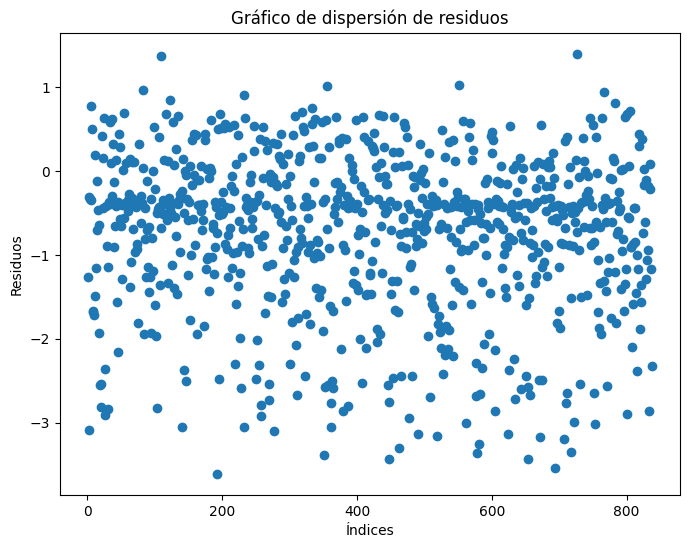

In [165]:
#residuos de la prediccion
residuals = y_train - y_pred
indices = list(range(1, len(y_train)+1))

# Crear una figura y ejes
plt.figure(figsize=(8, 6))

# Graficar los residuos
plt.scatter(indices, residuals)

# Agregar etiquetas y título
plt.xlabel('Índices')
plt.ylabel('Residuos')
plt.title('Gráfico de dispersión de residuos')

# Mostrar la gráfica
plt.show()

#### 4.8 Entrenamiento de un segundo modelo de regresión lineal (LASSO)

Se dice que la regresión es lineal dado que se asume una relación lineal entre las variables de entrada (features) y la variable objetivo (target).
En Scikit-Learn existen varias formas de implementar el algoritmo de regresión lieal, pero dado que el objetivo de esta practica esta enfocado en el análisis del modelo resultante y no tanto del algoritmo o del proceso de entrenamiento, se utilizará la implementación más sencilla dada por la clase LinearRegression.

In [166]:
# Crear el modelo
model_lasso = Lasso(alpha=0.01)

# Entrenar el modelo
model_lasso.fit(X_train, y_train)

# Initialize an empty list to store selected features
selected_features = []
selected_features_index = []
feature_names = X.columns
for i, feature in enumerate(feature_names):
  if abs(model_lasso.coef_[i]) > 0.0001:
    selected_features.append(feature)
    selected_features_index.append(i)
    print(f"Coeficiente de {feature}: {model_lasso.coef_[i]}")

print("Intercept: ", model_lasso.intercept_[0])

Coeficiente de targeted_productivity: 0.3809767366600542
Coeficiente de smv: -0.3324459146662267
Coeficiente de wip: 0.028501841158882105
Coeficiente de over_time: -0.030850999257934743
Coeficiente de idle_men: -0.15358470353219753
Coeficiente de no_of_workers: 0.3868219355973268
Coeficiente de quarter_Quarter3: -0.020128916594926504
Coeficiente de quarter_Quarter4: -0.07550511854576951
Coeficiente de quarter_Quarter5: 0.19899424313377045
Coeficiente de department_finishing : 0.30591094742216646
Coeficiente de day_Saturday: 0.11709543237901011
Coeficiente de day_Thursday: -0.03783488131588313
Coeficiente de day_Tuesday: 0.047487169504481855
Coeficiente de team_3: 0.19119300677364345
Coeficiente de team_4: 0.0670599609613948
Coeficiente de team_6: -0.15225833591486823
Coeficiente de team_7: -0.24830205768084224
Coeficiente de team_8: -0.17229669258744135
Coeficiente de team_10: -0.19738209997984366
Coeficiente de team_11: -0.32298966451272676
Coeficiente de no_of_style_change_1: -0.2342

**Validación Cuantitativa**

In [168]:
# Obtener las predicciones para el set Train
y_pred_lasso = model_lasso.predict(X_train)
y_train_original = y_train
y_pred_lasso = scaler_y.inverse_transform(y_pred_lasso.reshape(-1,1))
y_train_original = scaler_y.inverse_transform(y_train)
# MAE
mae_lasso  = mean_absolute_error(y_train_original, y_pred_lasso)
# MSE
mse_lasso  = mean_squared_error(y_train_original, y_pred_lasso)
# RMSE
rmse_lasso  = np.sqrt(mse)
# Imprimir los resultados
print("MAE:", mae_lasso)
print("MSE:", mse_lasso)
print("RMSE:", rmse_lasso)
print("R2:", model_lasso.score(X_train,y_train))

MAE: 0.10266400303960817
MSE: 0.020131329721117856
RMSE: 0.13792776787559435
R2: 0.3431259139468431


In [169]:
# Obtener las predicciones para el set Test
y_pred_test_lasso = model_lasso.predict(X_test)
y_test_original = y_test
y_pred_test_lasso = scaler_y.inverse_transform(y_pred_test_lasso.reshape(-1,1))
y_test_original = scaler_y.inverse_transform(y_test)
# MAE
mae_lasso = mean_absolute_error(y_test_original, y_pred_test_lasso)
# MSE
mse_lasso = mean_squared_error(y_test_original, y_pred_test_lasso)
# RMSE
rmse_lasso = np.sqrt(mse)
# Imprimir los resultados
print("MAE:", mae_lasso)
print("MSE:", mse_lasso)
print("RMSE:", rmse_lasso)
print("R2:", model_lasso.score(X_test,y_test))

MAE: 0.10803860711161523
MSE: 0.023707909904563687
RMSE: 0.13792776787559435
R2: 0.206776561018434


**Validación Cualitativa**

In [139]:
X_train_df = pd.DataFrame(X_train, columns=X.columns)

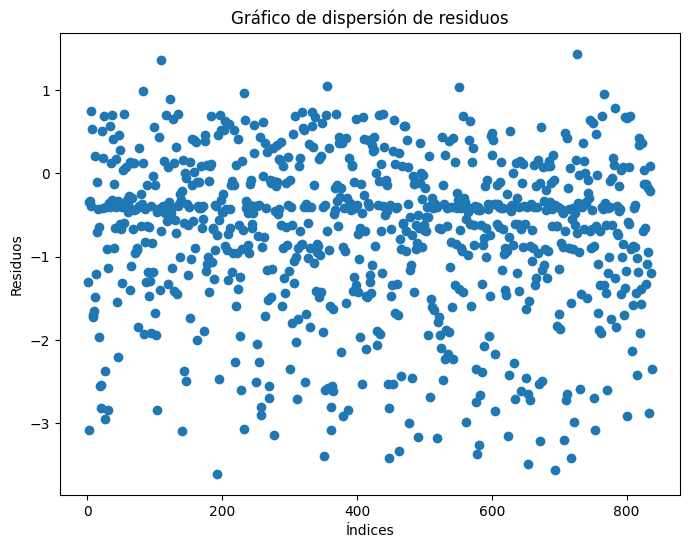

In [170]:
#residuos de la prediccion
residuals = y_train - y_pred_lasso.reshape(-1, 1)
indices = list(range(1, len(y_train)+1))

# Crear una figura y ejes
plt.figure(figsize=(8, 6))

# Graficar los residuos
plt.scatter(indices, residuals)

# Agregar etiquetas y título
plt.xlabel('Índices')
plt.ylabel('Residuos')
plt.title('Gráfico de dispersión de residuos')

# Mostrar la gráfica
plt.show()

#### 4.9 Entrenamiento de un tercer modelo de regresión lineal (BAGGING)

Se dice que la regresión es lineal dado que se asume una relación lineal entre las variables de entrada (features) y la variable objetivo (target).
En Scikit-Learn existen varias formas de implementar el algoritmo de regresión lieal, pero dado que el objetivo de esta practica esta enfocado en el análisis del modelo resultante y no tanto del algoritmo o del proceso de entrenamiento, se utilizará la implementación más sencilla dada por la clase LinearRegression.

In [171]:
from sklearn.ensemble import BaggingRegressor

# Crear el modelo base (Lasso)
model = LinearRegression()

# Crear el modelo Bagging con Lasso como estimador base
bagging_lasso = BaggingRegressor(base_estimator=model, n_estimators=15, random_state=42)

# Entrenar el modelo Bagging
bagging_lasso.fit(X_train[:, selected_features_index], y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingRegressor(base_estimator=LinearRegression(), n_estimators=15,
                 random_state=42)

**Validación Cuantitativa**

In [172]:
# Obtener las predicciones para el conjunto de entrenamiento
y_pred_train_bagging = bagging_lasso.predict(X_train[:, selected_features_index])
y_train_original = y_train
y_pred_train_bagging = scaler_y.inverse_transform(y_pred_train_bagging.reshape(-1,1))
y_train_original = scaler_y.inverse_transform(y_train)

# Calcular las métricas de evaluación para el conjunto de entrenamiento
mae_train_bagging = mean_absolute_error(y_train_original, y_pred_train_bagging)
mse_train_bagging = mean_squared_error(y_train_original, y_pred_train_bagging)
rmse_train_bagging = np.sqrt(mse_train_bagging)
r2_train_bagging = bagging_lasso.score(X_train[:, selected_features_index], y_train)


# Imprimir las métricas de evaluación
print("Métricas de evaluación para el conjunto de entrenamiento:")
print("MAE:", mae_train_bagging)
print("MSE:", mse_train_bagging)
print("RMSE:", rmse_train_bagging)
print("R2:", r2_train_bagging)

Métricas de evaluación para el conjunto de entrenamiento:
MAE: 0.10239839841940647
MSE: 0.019462427083545307
RMSE: 0.13950780294859963
R2: 0.3649518347777506


In [173]:
# Obtener las predicciones para el conjunto de prueba
y_pred_test_bagging = bagging_lasso.predict(X_test[:, selected_features_index])
y_test_original = y_test
y_pred_test_bagging = scaler_y.inverse_transform(y_pred_test_bagging.reshape(-1,1))
y_test_original = scaler_y.inverse_transform(y_test)

# Calcular las métricas de evaluación para el conjunto de prueba
mae_test_bagging = mean_absolute_error(y_test_original, y_pred_test_bagging)
mse_test_bagging = mean_squared_error(y_test, y_pred_test_bagging)
rmse_test_bagging = np.sqrt(mse_test_bagging)
r2_test_bagging = bagging_lasso.score(X_test[:, selected_features_index], y_test)

# Imprimir los resultados
print("Métricas de evaluación para el conjunto de prueba:")
print("MAE:", mae_test_bagging)
print("MSE:", mse_test_bagging)
print("RMSE:", rmse_test_bagging)
print("R2:", r2_test_bagging)

Métricas de evaluación para el conjunto de prueba:
MAE: 0.11284934110606655
MSE: 1.41002227389941
RMSE: 1.1874435876703406
R2: 0.19238729584100123


**Validación Cualitativa**

In [144]:
X_train_df = pd.DataFrame(X_train, columns=X.columns)

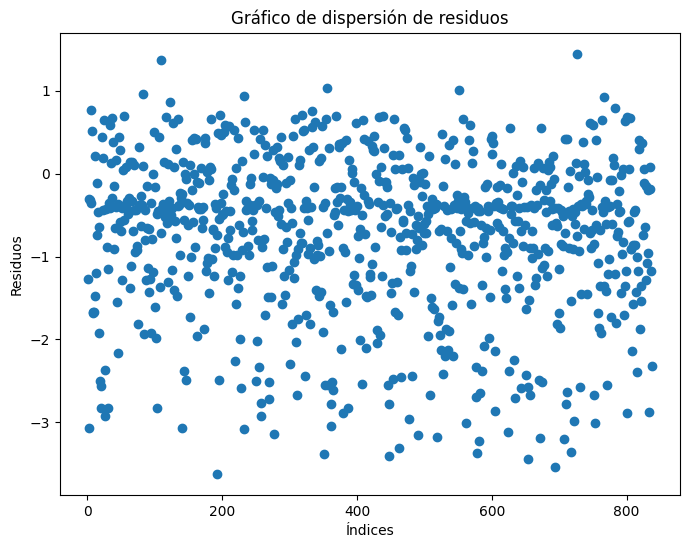

In [174]:
#residuos de la prediccion
residuals = y_train - y_pred_train_bagging.reshape(-1, 1)
indices = list(range(1, len(y_train)+1))

# Crear una figura y ejes
plt.figure(figsize=(8, 6))

# Graficar los residuos
plt.scatter(indices, residuals)

# Agregar etiquetas y título
plt.xlabel('Índices')
plt.ylabel('Residuos')
plt.title('Gráfico de dispersión de residuos')

# Mostrar la gráfica
plt.show()